In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from nas_wot import score
from MNISTConvNet import MNISTConvNet

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

In [2]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [3]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                        name='learning_rate')

dim_num_conv_layers = Integer(low=1, high=3, name='num_conv_layers')

dim_num_fc_units = Integer(low=5, high=512, name='num_fc_units')

dim_dropout_rate = Real(low=1e-5, high=1e-2, prior='log-uniform',
                        name='dropout_rate')

dimensions = [dim_learning_rate,
              dim_num_conv_layers,
              dim_num_fc_units,
              dim_dropout_rate]

default_parameters = [1e-5, 1, 16, 1e-4]

In [4]:
train_set = torchvision.datasets.MNIST(
                        root='./data/MNIST',
                        train=True,           #Training Set of 60,000 images
                        download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0, 1)
                        ])
)

test_set = torchvision.datasets.MNIST(
                        root='./data/MNIST',
                        train=False,          #Test Set of 10,000 images
                        download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0, 1)
                        ])
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=100
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=100
)

In [5]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [6]:
def train(model, lr, num_epoch, train_loader, test_loader):
    
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epoch):
        total_loss = 0
        total_correct = 0

        for batch in train_loader:
            images, labels = batch
            
            preds = model(images)
            loss = F.cross_entropy(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)

        print('epoch:', epoch, 'total_correct:', total_correct, 'loss:', total_loss)

    print('Train Accuracy:', total_correct/len(train_set))

    test_loss = 0
    test_correct = 0

    for batch in test_loader:
        images, labels = batch

        preds = model(images)
        loss = F.cross_entropy(preds, labels)
        
        test_loss += loss.item()
        test_correct += get_num_correct(preds, labels)

    print('Test Accuracy:', test_correct/len(test_set))
    
    return test_correct/len(test_set)

In [7]:
best_accuracy = 0.0
best_model_path = './best_model.pth'

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_conv_layers,
            num_fc_units, dropout_rate):

    print('\n\nlearning rate: {0:.1e}'.format(learning_rate))
    print('num_conv_layers:', num_conv_layers)
    print('num_fc_units:', num_fc_units)
    print('dropout_rate:', dropout_rate)
    
    model = MNISTConvNet(num_conv_layers=num_conv_layers,
                         num_fc_units=num_fc_units,
                         dropout_rate=dropout_rate)

    accuracy = train(model, learning_rate, 1, train_loader, test_loader)

    print('Accuracy:', accuracy)

    global best_accuracy

    if accuracy > best_accuracy:
        torch.save(model, best_model_path)
        best_accuracy = accuracy

    del model

    return -accuracy

In [8]:
fitness(x=default_parameters)



learning rate: 1.0e-05
num_conv_layers: 1
num_fc_units: 16
dropout_rate: 0.0001
epoch: 0 total_correct: 7207 loss: 1365.7161564826965
Train Accuracy: 0.12011666666666666
Test Accuracy: 0.1696
Accuracy: 0.1696


-0.1696

In [9]:
best_accuracy

0.1696

In [10]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI',
                            n_calls=12,
                            x0=default_parameters)



learning rate: 1.0e-05
num_conv_layers: 1
num_fc_units: 16
dropout_rate: 0.0001
epoch: 0 total_correct: 8798 loss: 1378.9494807720184
Train Accuracy: 0.14663333333333334
Test Accuracy: 0.1622
Accuracy: 0.1622


learning rate: 2.5e-05
num_conv_layers: 2
num_fc_units: 125
dropout_rate: 0.001796085286350762
epoch: 0 total_correct: 15882 loss: 1364.5489072799683
Train Accuracy: 0.2647
Test Accuracy: 0.4914
Accuracy: 0.4914


learning rate: 5.4e-04
num_conv_layers: 3
num_fc_units: 52
dropout_rate: 0.0008905592246977513
epoch: 0 total_correct: 28704 loss: 880.2016779184341
Train Accuracy: 0.4784
Test Accuracy: 0.6568
Accuracy: 0.6568


learning rate: 1.2e-05
num_conv_layers: 2
num_fc_units: 313
dropout_rate: 2.8391575704721965e-05
epoch: 0 total_correct: 11011 loss: 1369.5675468444824
Train Accuracy: 0.18351666666666666
Test Accuracy: 0.272
Accuracy: 0.272


learning rate: 5.6e-03
num_conv_layers: 2
num_fc_units: 223
dropout_rate: 4.235958405745658e-05
epoch: 0 total_correct: 55621 loss: 1

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

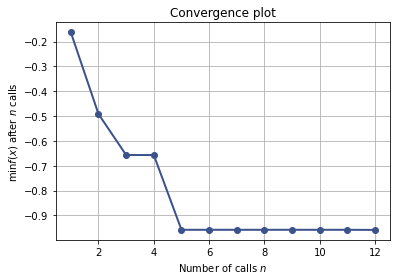

In [11]:
plot_convergence(search_result)

In [12]:
search_result.x

[0.01, 1, 371, 0.0020373556352574866]

In [17]:
space = search_result.space

In [15]:
type(search_result)

scipy.optimize.optimize.OptimizeResult

In [19]:
search_result.fun

-0.9585

In [20]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.9585, [0.01, 1, 371, 0.0020373556352574866]),
 (-0.958, [0.0055907118261023046, 2, 223, 4.235958405745658e-05]),
 (-0.9404, [0.0008260939303352365, 2, 488, 0.0018843111126491078]),
 (-0.6568, [0.0005430212117300351, 3, 52, 0.0008905592246977513]),
 (-0.5447, [8.071479225631815e-06, 1, 171, 0.0006862299423554364]),
 (-0.4914, [2.543226725130005e-05, 2, 125, 0.001796085286350762]),
 (-0.272, [1.2005457717148208e-05, 2, 313, 2.8391575704721965e-05]),
 (-0.1622, [1e-05, 1, 16, 0.0001]),
 (-0.1149, [1.0596205281241633e-06, 2, 322, 9.769567507373085e-05]),
 (-0.1082, [1.0054745084854189e-05, 1, 15, 8.107826584332653e-05]),
 (-0.1041, [2.4882391096055274e-06, 2, 300, 4.438258157420633e-05]),
 (-0.0997, [3.892043891201965e-06, 3, 444, 0.00033865735008855403])]

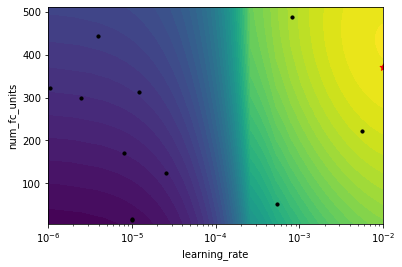

In [22]:
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_fc_units',
                        levels=50)

In [8]:
model = torch.load(best_model_path)

In [68]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

In [79]:
from model_utils import Network

In [80]:
network = Network()

In [10]:
# MNISTConvNet Model with MNIST

for i in range(5):
    print(score(model, train_loader, 100))

C:\Users\kaies\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\kaies\AppData\Roaming\Python\Python37\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Array must not contain infs or NaNs
-261.7012142274709
Array must not contain infs or NaNs
-1270.004067179709
-266.3403546270092
Array must not contain infs or NaNs
Array must not contain infs or NaNs
-266.2879589093274
-266.0823989199623


In [78]:
# MNISTConvNet Model with FashionMNIST

score(model, train_loader, 100)

-174.53300854914806

In [84]:
# DeepLizard Model with FashinMNIST

for i in range(5):
    print(score(network, train_loader, 100))

-130.0591546563784
-129.5577054965591
-130.10801703043032
-130.50272044612768
-130.20478774893365


In [86]:
# DeepLizard Model with MNIST

for i in range(5):
    print(score(network, train_loader, 100))

-140.72732323378915
-140.93314403853495
-140.58060849670062
-140.8401433763754
-141.25414008094714
